This tutorial will demonstrate how to:
- fit tuning curves given behavioral labels (e.g. position)
- perform state-space decoding in the fashion of [Denovellis et. al. (2021)](https://elifesciences.org/articles/64505). It gives the posterior probability of the *label* and the *dynamics type* (they call it continuous and discrete variable, repsectively). 
    - *dynamics type* specifies the temporal prior of the label. When the dynamics type is *continuous*, the temporal prior of the label is a gaussian random walk, with a movement variance specified by the user. When the dynamics type is *fragmented*, the temporal prior of the label is uniform across all possible bins.


# import  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import poor_man_gplvm as pmg
import poor_man_gplvm.plot_helper as ph
import pynapple as nap
import numpy as np
import pandas as pd

# Load the data (ignore this section and replace with your own data)
Some words on data preprocessing. We highly recommend [pynapple](https://pynapple.org/) as an entry point for neural data analysis in Python. They wrap around numpy objects but provide additional useful functionalities like restricting to time intervals, aligning to common time stamps, and turn spike times into counts. 

Knowledge with [numpy](https://numpy.org/), [xarray](https://docs.xarray.dev/), and [pandas](https://pandas.pydata.org/) will also be helpful.

Essentially, for this tutorial, we need: 
- *spk_times*: pynapple TsGroup, obtained from a list of spike times (from the entire recording) for each unit.
- *position_tsdf*: pynapple TsdFrame, obtained from an array of (n_time, n_columns), timestamps, and column names. Each column is one behavior label we will decode (doesn't have to be position).
- *behavior_ep*: pynapple IntervalSet, obtained from arrays of start and end times of the behavior epoch when tuning curve is computed. 
- *speed_tsd* (optional): pynapple Tsd, obtained from an array of (n_time,) and timestamps. Here it is used for subselecting the locomotion epochs to include in the tuning curve computation. 

For the replay analysis later, we also need:
- *ep_full*: pynapple IntervalSet, for the whole recording where replay will be identified 
- *ep_nrem*: pynapple IntervalSet, for the non-REM episodes


In [11]:
import sys,os
sys.path.append('../../poor_gplvm/code')
import preprocess_roman_tmaze as preprt



data_dir_full = preprt.db_roman.iloc[0]['data_dir_full']

prep_res = nap.load_folder(os.path.join(data_dir_full, "derivatives"))  


spk_times = prep_res["spk_times"]
ripple_intervals = prep_res["ripple_intervals"]
position_tsdf = prep_res["position_tsdf"]
behavior_ep = prep_res['behavior_ep']


behavior_ep = prep_res['behavior_ep']
speed_tsd = prep_res['speed_tsd']

# epochs for replay analysis
ep_full = prep_res['full_ep']
ep_nrem = prep_res['sleep_state_intervals_NREMepisode']

# Prepare the data

## turn spike train into a matrix (TsdFrame, n_time x n_neuron) of spike counts 
Optional: use a mask to subselect only the pyramidal cells. This is easy if the relevant mask, e.g. *is_pyr* (whether it is a pyramidal cell) is stored as a metadata in the TsGroup.


In [4]:
spk_times_pyr=spk_times[spk_times['is_pyr']]
spk_mat = spk_times_pyr.count(0.1,ep=behavior_ep)

## prepare the labels and hyperparameters
### labels
In the paradigm of spatial navigation, the `label_d` can be time series of:
- linearized positions 
- 2D positions 
- [choice port ID](https://www.nature.com/articles/s41586-024-08397-7)
- linearized positions + direction
- 2D positions + direction

Indeed, in contrast to existing libraries of spatial decoding, we allow for arbitrary numbers of label dimension (up to memory constraint, so practically if one is already using 2D positions, the extra dimensions should not have too many discretized bins). 

Even for a linearizeable maze like the alternating T-maze, I personally still prefer using the 2D positions as labels. Whereas for a linear track, I would use the 1D position + direction, although 2D could give a subtler picture as hinted by [Zutshi et. al. (2025)](https://www.nature.com/articles/s41586-024-08397-7).


### Hyperparameters
- `label_bin_size`: binsize for discretizing the labels. 
- `smooth_std`: the standard deviation of the Gaussian kernel for smoothing the tuning curves. If None then no smoothing.
- `occupancy_threshold`: the occupancy threshold (in seconds) for the label bin to be considered valid. 

All of the above can be either: 1) a single number that apply to all the dimensions; 2) a list of value per dimension; and 3) for multiple mazes, a dictionary of {maze_key: val}, where val can be 1) or 2). This means for multiple mazes different labels can be provided for different mazes.

Here we will demonstrate the more general syntax assuming multiple mazes, but know that it can be simplified.

In [5]:
label_d= {} 
label_d['familiar']=position_tsdf[['x','y']].restrict(behavior_ep[0]) # The restrict limit the x y coordinates to the first behavior epoch

ep_d={}
ep_d['familiar'] = speed_tsd.restrict(behavior_ep[0]).threshold(5).time_support

label_bin_size_d = {}
label_bin_size_d['familiar'] =  3.

smooth_std_d = {}
smooth_std_d['familiar'] = 3.


## below is if there's a second novel linear maze, with time_window given by `behavior_ep[1]`

In [ ]:
# novel_lin=position_tsdf[['lin']].restrict(behavior_ep[1])

# novel_lin_dir = novel_lin.derivative() > 0

# beh_tsdf_novel=nap.TsdFrame(d=np.stack([novel_lin.d,novel_lin_dir.d.astype(int)],axis=1),t=novel_lin.t,columns=['lin','dir'])

# label_d['novel'] = beh_tsdf_novel

# speed_tsd_novel = np.abs(novel_lin.derivative())

# ep_d['novel'] = speed_tsd_novel.threshold(5).time_support



# label_bin_size_d['novel'] = [3.,1.]

# smooth_std_d['novel'] = [3,None]

# compute tuning curves
Tuning curves are computed by: 1) discretize the multi-dimensional labels into bins; 2) get occupancy of each bin; 3) drop the low occupancy bins; 4) compute the spike counts emitted within each bin; 5) smooth the occupancy and spike counts using a Gaussian kernel; 6) FR = count_smoothed / occupancy_smoothed, in Hz

In [6]:
from importlib import reload
reload(pmg)

<module 'poor_man_gplvm' from '/mnt/home/szheng/projects/poor-man-GPLVM/poor_man_gplvm/__init__.py'>

In [7]:
tuning_res = pmg.get_tuning_supervised(
    spk_mat,# nap.TsdFrame, n_time x n_neuron
    label_d,
    ep=ep_d,                   # nap.IntervalSet (optional)
    label_bin_size=label_bin_size_d,          # cm
    smooth_std=smooth_std_d,              # cm, Gaussian kernel std
    occupancy_threshold=0.1,     # seconds
)



[get_tuning] maze=familiar: grid_shape=(29, 28), n_neurons=422, dt=0.1000s, n_valid_time=8930, n_occupied_bins=306


In [34]:
print(tuning_res.keys())

dict_keys(['tuning', 'occupancy', 'occupancy_smth', 'spk_count', 'spk_count_smth', 'bin_edges', 'bin_centers', 'label_grid_centers', 'grid_shape', 'label_dim_names', 'neuron_names', 'occupied_mask', 'valid_flat_mask', 'dt', 'smoothing_matrix', 'n_valid_timepoints', 'tuning_flat', 'occupancy_flat', 'occupancy_smth_flat', 'spk_count_flat', 'spk_count_smth_flat', 'coord_to_flat_idx', 'flat_idx_to_coord'])


Some important keys of the `tuning_res`:
- `tuning`: Dictionary {maze_key: tuning_per_maze}; tuning_per_maze: xarray.DataArray, (n_label_dim_1_bin, n_label_dim_2_bin, ..., n_neuron). This representation is easier for plotting
- `tuning_flat`: array of (n_label_bin_total, n_neuron). All valid bins are concatenated together. This representation is easier for decoders
- `coord_to_flat_idx`: Dictionary {maze_key: pandas.Series}, the index are the label bin centers and the value is the index within the flattened label bins.
- `flat_idx_to_coord`: Pandas.DataFrame, index is the index within the flattened label bins, and columns are maze key plus all the labels.

example spatial tuning of a neuron

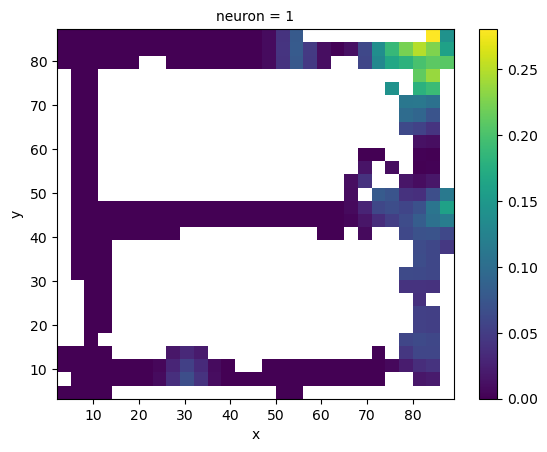

In [49]:
tuning_res['tuning']['familiar'].isel(neuron=0).T.plot() 


In [80]:
coord_to_flat_idx=tuning_res['coord_to_flat_idx']
coord_to_flat_idx

{'familiar': x          y        
 3.550231   4.755008       0
            10.755008      1
            13.755008      2
            79.755008      3
            82.755008      4
                        ... 
 87.550231  46.755008    301
            49.755008    302
            79.755008    303
            82.755008    304
            85.755008    305
 Length: 306, dtype: int64}

In [81]:
flat_idx_to_coord=tuning_res['flat_idx_to_coord']
flat_idx_to_coord.head()

,maze,x,y
flat_idx,,,
0,familiar,3.550231,4.755008
1,familiar,3.550231,10.755008
2,familiar,3.550231,13.755008
3,familiar,3.550231,79.755008
4,familiar,3.550231,82.755008


# Replay analysis 

## preprocessing for replay analysis

### Identify population burst events
We bin spikes finely (`bin_size`,default 2ms), average across neurons (pyramidal cells), lightly smooth (`smooth_std`, default 7.5ms), z-score, identify the windows where the firing rate reachs beyond 3 standard deviations `z_thresh`, and extend both sides of the window back to the mean. The events are filtered by a `min_duration` and `max_duration`.

- `ep`: pynapple IntervalSet, time epochs where the population burst events are to be identified
- `threshold_ep`: pynapple IntervalSet, time epochs where the mean and standard deviation of firing rates are computed. Here we choose only the non-REM epochs.
- `force_reload`: whether to re-compute if the file already exists
- `dosave`: whether to save
- `return_population_rate`: whether to return the population firing rate, since it can be a long time series

Can optionally supply `ripple_intervals` (pynapple IntervalSet) so that the detected PBE is aware of how many sharp wave ripples are contained within. If not provided, then the `n_ripples` column will be 0!

In [12]:
%%time
# get pbe
import poor_man_gplvm.post_fit_workflow.get_event_windows as gew

is_pyr = spk_times['is_pyr'] # assuming is_pyr is in the metadata of spk_times; otherwise a boolean array of length n_neuron would work
spk_times_pyr=spk_times[is_pyr] 
pbe_save_dir=os.path.join(data_dir_full,'py_data') # replace with the directory you like!
save_fn='pbe.p'#'pbe_wake_and_sleep_all.p'#


pbe_res=gew.detect_population_burst_event(spk_times_pyr, mask=None, ep=ep_full,threshold_ep=prep_res['sleep_state_intervals_NREMepisode'], bin_size=0.002, smooth_std=0.0075, 
                                 z_thresh=3.0, min_duration=0.05, max_duration=0.5,
                                 ripple_intervals=None,force_reload=False,dosave=False,save_dir=pbe_save_dir,return_population_rate=False,save_fn=save_fn)




/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/pbe.p exists; loading---
CPU times: user 97.1 ms, sys: 6.88 ms, total: 104 ms
Wall time: 150 ms


In [102]:
event_windows=pbe_res['event_windows']
event_windows

index    start      end        n_ripples
0        232.875    233.018    0
1        233.076    233.205    0
2        233.528    233.602    0
3        234.005    234.058    0
4        236.802    236.878    0
5        238.391    238.541    0
6        238.584    238.647    0
...      ...        ...        ...
5393     16504.692  16504.788  0
5394     16505.522  16505.604  0
5395     16508.898  16509.059  0
5396     16509.306  16509.4    0
5397     16526.068  16526.271  0
5398     16528.204  16528.257  0
5399     16528.276  16528.411  0
shape: (5400, 2), time unit: sec.

### Bin spikes
To work with data grouped by events / trials, we use a helper function that takes in `spk_times` (pynapple TsGroup) and `binsize` (default 0.02 s) and bin the spikes into two formats: `spike_tensor` and `spike_mat`, and return other useful information. The returned Dictionary has the following keys:

- `spike_tensor`: array of shape (n_event, n_time_max, n_neuron), binned spikes seperated by event; all events padded to the same length.  
- `spike_mat`: TsdFrame of shape (n_time_concat, n_neuron), concatenated spike counts
- `time_l`: time stamps, (n_time_concat,) 
- `event_index_per_bin`: index of the event at each concatenated time bin, (n_time_concat,)
- `mask`: mask showing the padding for the tensor; (n_event, n_time_max, 1); True means the time bin is in the event and not padded
- `time_per_trial`: List of arrays (unequal lengths), each containing the time stamps of each event 





In [77]:
import poor_man_gplvm.trial_analysis as tri
binsize = 0.02
spk_tensor_res=tri.bin_spike_train_to_trial_based(spk_times_pyr,pbe_res['event_windows'],binsize=binsize) # here we use the pyramidal cells only but you could also do all cells; just need to match with the tuning curves!

spk_tensor=spk_tensor_res['spike_tensor']
spk_mat_pbe=spk_tensor_res['spike_mat']
tensor_pad_mask=spk_tensor_res['mask']
time_l =spk_tensor_res['time_l']

In [78]:
print('Tensor format shape (n_event, n_time_max, n_neuron)',spk_tensor.shape)
print('Matrix format shape (n_time_concat, n_neuron)',spk_mat_pbe.shape)
print('Tensor pad mask shape (n_event, n_time_max, 1)',tensor_pad_mask.shape)
print('time stamps shape (n_time_concat,)',time_l.shape)

Tensor format shape (n_event, n_time_max, n_neuron) (5400, 25, 422)
Matrix format shape (n_time_concat, n_neuron) (30532, 422)
Tensor pad mask shape (n_event, n_time_max, 1) (5400, 25, 1)
time stamps shape (n_time_concat,) (30532,)


# First question - whether an event is better-explained by the tuning templates than chance (goodness-of-fit, "on-manifold"ness)
For the first question we measure the model fit by the marginal likelihood of the Naive Bayes decoder. There is no temporal prior. It is asking whether the population vectors from one event lie on the manifold of tuning curves, ignoring any question about temporal sequenceness. 

We use two shuffles to answer this question:
- *Neuron ID shuffle*: check whether the Neuron - tuning curve association is needed for the model fit
- *Circular shuffle*: check whether the **co-activity** is driving the model fit (rather than single neuron firing statistics)

Usually the *circular shuffle* test is harder to pass. We recommened using the `is_sig_overall==True` events for downstream quantitative analysis.


In [141]:
reload(shuf)

<module 'poor_man_gplvm.post_fit_workflow.shuffle_test_decoding' from '/mnt/home/szheng/projects/poor-man-GPLVM/poor_man_gplvm/post_fit_workflow/shuffle_test_decoding.py'>

In [144]:
import poor_man_gplvm.post_fit_workflow.shuffle_test_decoding as shuf

dt = binsize # binsize during PBEs as was used before, 0.02s default
gain = 1 # multiply the tuning by a scalar to reflect possible change in firing rate, default 1
save_dir='./' # replace
save_fn='supervised_shuffle.p' # replace

tuning_flat = tuning_res['tuning_flat']
flat_idx_to_coord = tuning_res['flat_idx_to_coord']
event_index_per_bin = spk_tensor_res['event_index_per_bin']
spk_mat_pbe = spk_tensor_res['spike_mat']

shuffle_res = shuf.shuffle_test_naive_bayes_marginal_l(
    spk_mat_pbe,
    event_index_per_bin,
    tuning=tuning_flat,
    n_shuffle=100,
    sig_thresh=0.95,
    seed=0,
    decoding_kwargs={'dt': dt, 'gain': gain, 'n_time_per_chunk': 20000},
    dosave=False,
    force_reload=False,
    save_dir=save_dir,
    save_fn=save_fn,
)

[shuffle_test_naive_bayes_marginal_l] chunk: decode true
[shuffle_test_naive_bayes_marginal_l] chunk: init shuffle stats
[shuffle_test_naive_bayes_marginal_l] chunk: decode shuffles (tqdm)


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

[shuffle_test_naive_bayes_marginal_l] chunk: quantiles + significance
[shuffle_test_naive_bayes_marginal_l] chunk: expand is_sig_overall to time bins


In [145]:
shuffle_res.keys()

dict_keys(['event_df', 'log_marginal_id_q_df', 'log_marginal_circular_q_df', 'decode_true', 'is_sig_mask_time', 'is_sig_frac', 'meta'])

In [149]:
event_df_shuffle=shuffle_res['event_df']
event_df_shuffle.head()

,event_i,start_index,end_index,log_marginal_per_event_true,id_shuffle_thresh,circular_shuffle_thresh,is_sig_id_shuffle,is_sig_circular_shuffle,is_sig_overall
0,0.0,0,7,-571.643372,-703.281146,-538.960324,True,False,False
1,1.0,7,13,-607.216858,-665.691956,-577.143777,True,False,False
2,2.0,13,17,-264.073059,-326.292525,-266.887338,True,True,True
3,3.0,17,20,-228.237305,-259.336310,-218.944244,True,False,False
4,4.0,20,24,-300.522644,-342.154828,-286.572789,True,False,False


The columns `is_sig_xx` indicates whether the event is significant under the particular shuffle, "overall" for both tests.

# Second question: is there spatially coherent content and quantify the metrics of spatial replays

### Decode with dynamics

For this question, we use the state-space decoder from [Denovellis et. al. (2021)](https://elifesciences.org/articles/64505) (we only include the *continuous* and *fragmented* dynamics, lumping *stationary* into *continuous*). The probability of *continuous* dynamics gives a measure for how smoothly the decoded trajectory evolve as opposed to jumping around. 

The essential inputs are:
- `spk_tensor`: (n_event, n_time_max, n_neuron) from `bin_spike_train_to_trial_based`
- `tuning_flat`: (n_label_bin_total, n_neuron) from `get_tuning_supervised`
- `tensor_pad_mask`: (n_event, n_time_max,1), `mask` from the result from `bin_spike_train_to_trial_based`
- `dt`: binsize during PBEs as was used before, 0.02s default
- `gain`: multiply the tuning by a scalar to reflect possible change in firing rate, default 1


The hyperparameters we need to specify: 
- `continuous_transition_movement_variance`: this variable mirrors `smooth_std` in `get_tuning_supervised`; the variance of the random walk under the *continuous* dynamics (in the unit of label_unit^2 per time bin!). E.g. 100 if the position label has the unit of cm means typically a movement of 10cm per time bin.
- `p_move_to_jump`: prior transition probability of the dynamics type from *continuous* to *fragmented*  
- `p_jump_to_move`: vice versa

Helpful labels that will make the output nicer:

- `time_l`: from `bin_spike_train_to_trial_based`
- `coord_to_flat_idx`: from `get_tuning_supervised`
- `flat_idx_to_coord`: from `get_tuning_supervised`

Hardware constraint related (can skip):
- `n_time_per_chunk`: when the total number of time points is large, doing `jax.lax.scan` can run into memory issues. We thus break the data up into chunks, each with this size.


As reported by [Denovellis et. al. (2021)](https://elifesciences.org/articles/64505), the prior transition probability of the dynamics type won't qualitatively affect results. We recommend exploring different levels of `continuous_transition_movement_variance` to show robustness of any downstream analysis.  

In [72]:
import poor_man_gplvm.supervised_analysis.decoder_supervised as ds

In [69]:
movement_variance_d = ds.smooth_std_d_to_movement_variance_d(smooth_std_d) # an easy way to mirror the strucutre of smooth_std if it's complicated
print(movement_variance_d) 
movement_variance_d['familiar'] = 100. # can then change things in a targeted way
print(movement_variance_d) 


{'familiar': 9.0}
{'familiar': 100.0}


In [181]:
reload(ds)

<module 'poor_man_gplvm.supervised_analysis.decoder_supervised' from '/mnt/home/szheng/projects/poor-man-GPLVM/poor_man_gplvm/supervised_analysis/decoder_supervised.py'>

In [ ]:
%%time
# run decoding
decode_res = ds.decode_with_dynamics(
    spk_tensor,
    tuning_flat,
    tensor_pad_mask,
    dt=dt,
    gain=gain,
    time_l=time_l,
    coord_to_flat_idx=coord_to_flat_idx,
    flat_idx_to_coord=flat_idx_to_coord,
    continuous_transition_movement_variance=movement_variance_d,
    p_move_to_jump=0.02,
    p_jump_to_move=0.02,
    n_time_per_chunk=20000,
    observation_model="poisson",
)

In [179]:
decode_res['posterior_latent_marg_per_event']['familiar'][0]

<xarray.DataArray (time: 7, label_bin: 306)> Size: 9kB
array([[1.1488289e-03, 1.1271321e-01, 1.2408284e-01, ..., 1.4839341e-23,
        2.2921591e-23, 7.1774123e-24],
       [1.4012985e-45, 1.4524540e-31, 6.8677699e-29, ..., 4.1698082e-21,
        7.8709954e-24, 5.4381587e-29],
       [0.0000000e+00, 7.5046416e-38, 1.0619487e-35, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.7584785e-19, 9.6340382e-20, 3.0708289e-20, ..., 7.5895727e-33,
        6.8850902e-35, 5.4034431e-36],
       [1.8932179e-04, 2.7578708e-05, 2.6215130e-06, ..., 5.1341970e-02,
        5.9246816e-02, 9.6713724e-03],
       [6.8976326e-05, 2.4073820e-06, 8.1763096e-07, ..., 5.2223049e-07,
        1.3935171e-09, 6.3901677e-14]], dtype=float32)
Coordinates:
  * time       (time) float64 56B 232.9 232.9 232.9 232.9 233.0 233.0 233.0
  * label_bin  (label_bin) object 2kB MultiIndex
  * x          (label_bin) float64 2kB 3.55 3.55 3.55 3.55 ... 87.55 87.55 87.55
  * y          (label_bin) float64 2kB 4.755 10.76 13.76 ... 79.76 82.76 85.76

In [133]:
print(decode_res.keys())

dict_keys(['log_likelihood', 'log_posterior_all', 'posterior_all', 'log_posterior_latent_marg', 'posterior_latent_marg', 'posterior_dynamics_marg', 'log_marginal_per_event', 'log_marginal', 'n_time_per_event', 'start_index', 'end_index', 'tensor_pad_mask', 'log_latent_transition_kernel_l', 'log_dynamics_transition_kernel', 'log_likelihood_per_event', 'log_posterior_all_per_event', 'posterior_all_per_event', 'log_posterior_latent_marg_per_event', 'posterior_latent_marg_per_event', 'posterior_dynamics_marg_per_event', 'time_l', 'maze_l'])


The most important keys are:
- `posterior_latent_marg`: posterior probability of each label bin, marginalized over dynamics type, Dictionary {maze_key: post}, post: xarray.DataArray, (n_time_concatenated, n_label_bin). The `label_bin` is a multi-index that include all the label dimensions within that maze (here, 'x', and 'y')
- `posterior_dynamics_marg`: posterior probability of each dynamics type, marginalized over label bins. pynapple TsdFrame, (n_time_concatenated, 2), column 0 is for "continuous" dynamics, 1 is "jump"/"fragmented".

Additionally, 
- `start_index` and `end_index` provide the indices to select specific events out of the concatenated posterior
- `posterior_latent_marg_per_event` and `posterior_dynamics_marg_per_event` are the per event version of the above posteriors.

In [89]:
decode_res['posterior_latent_marg']

{'familiar': <xarray.DataArray (time: 30532, label_bin: 306)> Size: 37MB
 array([[1.1488289e-03, 1.1271321e-01, 1.2408284e-01, ..., 1.4839341e-23,
         2.2921591e-23, 7.1774123e-24],
        [1.4012985e-45, 1.4524540e-31, 6.8677699e-29, ..., 4.1698082e-21,
         7.8709954e-24, 5.4381587e-29],
        [0.0000000e+00, 7.5046416e-38, 1.0619487e-35, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [4.3858509e-27, 9.3137508e-21, 3.7608300e-20, ..., 4.0694730e-26,
         1.3126018e-29, 3.9609672e-36],
        [1.4022971e-06, 2.8968918e-08, 9.4302526e-12, ..., 5.2330796e-07,
         1.4585203e-07, 1.4213819e-10],
        [6.3777305e-05, 7.8007688e-05, 2.2702197e-06, ..., 1.4936184e-22,
         1.1198577e-22, 2.5994606e-23]], dtype=float32)
 Coordinates:
   * time       (time) float64 244kB 232.9 232.9 232.9 ... 1.653e+04 1.653e+04
   * label_bin  (label_bin) object 2kB MultiIndex
   * x          (label_bin) float64 2kB 3.55 3.55 3.55 3.55 ... 87.55 8

In [90]:
decode_res['posterior_dynamics_marg']

Time (s)    continuous            jump
----------  --------------------  ------------------
232.885     0.1258399933576584    0.8741599917411804
232.905     0.11007999628782272   0.8899199962615967
232.925     0.13821999728679657   0.8617799878120422
232.945     0.12902000546455383   0.8709800243377686
232.965     0.122529998421669     0.8774700164794922
232.985     0.08156000077724457   0.9184399843215942
233.005     0.004449999891221523  0.9955499768257141
...         ...                   ...
16528.286   0.04862000048160553   0.9513800144195557
16528.306   0.03181999921798706   0.9681800007820129
16528.326   0.03471999987959862   0.9652799963951111
16528.346   0.05025999993085861   0.9497399926185608
16528.366   0.0843999981880188    0.9156000018119812
16528.386   0.09126999974250793   0.9087299704551697
16528.406   0.08681000024080276   0.9131900072097778
dtype: float32, shape: (30532, 2)

### Replay metrics

Replay analysis can feel like finding needles in the haystack. To know where to look, it is extremely helpful to first quantify properties of the replay.

We treat continuous segments within an event as a basic unit of analysis, compute metrics like *displacement* (maximal euclidean distance from the start), *path length* (accumulated euclidean distance) and *speed*, and aggregate within each PBE (*max_displacement* is max across segments, *median_segment_speed* is median across segments, etc.). 

In our experience, replays of long trajectories are best selected by setting a threshold on *max_displacement*, (e.g. 20cm threshold on a 80 x 80cm figure-8 maze will only select 1% of the events, but they tend to look like nice long replays).  




In [134]:
%%time
import poor_man_gplvm.supervised_analysis.replay_metrics_supervised as rms
out = rms.compute_replay_metrics(decode_res["posterior_latent_marg"], decode_res["posterior_dynamics_marg"], start_index=decode_res["start_index"], end_index=decode_res["end_index"], binsize=dt, position_key={"familiar": ("x","y")}) 
metrics_df = out["metrics_df"]



CPU times: user 11.3 s, sys: 0 ns, total: 11.3 s
Wall time: 11.3 s


Now we can combine the time, shuffle result, and replay metrics all into one pandas DataFrame

In [150]:
event_windows_pd=event_windows.as_dataframe() # convert pynapple IntervalSet to pandas DataFrame
replay_metrics_df = pd.concat([event_windows_pd,metrics_df,event_df_shuffle],axis=1)
replay_metrics_df.head()

,start,end,n_ripples,n_bins,n_continuous_segments,median_segment_duration,max_segment_duration,total_continuous_bins,frac_continuous,duration_sec,...,event_i,event_i,start_index,end_index,log_marginal_per_event_true,id_shuffle_thresh,circular_shuffle_thresh,is_sig_id_shuffle,is_sig_circular_shuffle,is_sig_overall
0,232.875,233.018,0,7,0,0.0,0,0,0.0,0.14,...,0,0.0,0,7,-571.643372,-703.281146,-538.960324,True,False,False
1,233.076,233.205,0,6,0,0.0,0,0,0.0,0.12,...,1,1.0,7,13,-607.216858,-665.691956,-577.143777,True,False,False
2,233.528,233.602,0,4,0,0.0,0,0,0.0,0.08,...,2,2.0,13,17,-264.073059,-326.292525,-266.887338,True,True,True
3,234.005,234.058,0,3,1,3.0,3,3,1.0,0.06,...,3,3.0,17,20,-228.237305,-259.336310,-218.944244,True,False,False
4,236.802,236.878,0,4,0,0.0,0,0,0.0,0.08,...,4,4.0,20,24,-300.522644,-342.154828,-286.572789,True,False,False


We can check what fraction of events is significant

In [151]:
replay_metrics_df['is_sig_overall'].mean()

0.10388888888888889

Subselect only the significant events

In [153]:
replay_metrics_df_sig = replay_metrics_df.loc[replay_metrics_df['is_sig_overall']]
replay_metrics_df_sig

,start,end,n_ripples,n_bins,n_continuous_segments,median_segment_duration,max_segment_duration,total_continuous_bins,frac_continuous,duration_sec,...,event_i,event_i,start_index,end_index,log_marginal_per_event_true,id_shuffle_thresh,circular_shuffle_thresh,is_sig_id_shuffle,is_sig_circular_shuffle,is_sig_overall
2,233.528,233.602,0,4,0,0.0,0,0,0.000000,0.08,...,2,2.0,13,17,-264.073059,-326.292525,-266.887338,True,True,True
12,249.768,249.845,0,4,0,0.0,0,0,0.000000,0.08,...,12,12.0,63,67,-310.220093,-366.230363,-310.672313,True,True,True
29,291.767,291.845,0,4,1,4.0,4,4,1.000000,0.08,...,29,29.0,157,161,-467.618591,-586.539410,-470.330569,True,True,True
40,315.912,315.998,0,4,1,3.0,3,3,0.750000,0.08,...,40,40.0,207,211,-416.208832,-514.379868,-417.689360,True,True,True
73,379.211,379.493,0,14,0,0.0,0,0,0.000000,0.28,...,73,73.0,383,397,-1132.570923,-1419.046301,-1144.701416,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,16489.664,16489.804,0,7,1,6.0,6,6,0.857143,0.14,...,5382,5382.0,30427,30434,-859.177307,-1347.981805,-918.267075,True,True,True
5387,16494.868,16495.028,0,8,1,8.0,8,8,1.000000,0.16,...,5387,5387.0,30454,30462,-709.461426,-895.994568,-711.103690,True,True,True
5391,16497.895,16497.974,0,4,0,0.0,0,0,0.000000,0.08,...,5391,5391.0,30480,30484,-555.966064,-738.440646,-558.233441,True,True,True
5394,16505.522,16505.604,0,4,0,0.0,0,0,0.000000,0.08,...,5394,5394.0,30495,30499,-385.434265,-526.084674,-387.377599,True,True,True


Check the distribution of the max_displacement

<Axes: >

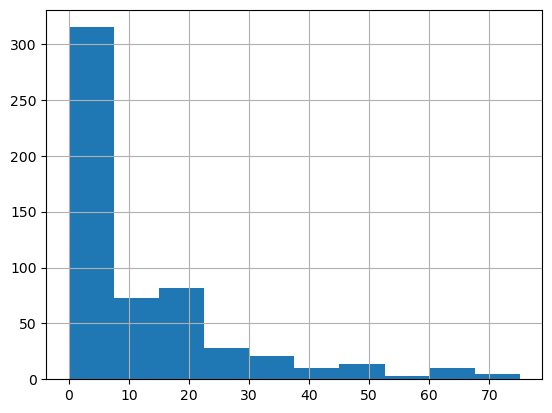

In [160]:
replay_metrics_df_sig['max_displacement'].hist()

### Visualize

Now let's find some long replay trajectories, using a threshold on `max_displacement` 

In [164]:
max_displacement_thresh = 20
replay_metrics_df_sig_long=replay_metrics_df_sig.loc[replay_metrics_df_sig['max_displacement'] > max_displacement_thresh]

In [166]:
ii=0 # pick the ii-th row
replay_metrics_df_sig_long.iloc[ii]

start                             588.178
end                               588.346
n_ripples                               0
n_bins                                  8
n_continuous_segments                   1
median_segment_duration               6.0
max_segment_duration                    6
total_continuous_bins                   6
frac_continuous                      0.75
duration_sec                         0.16
binsize                              0.02
state_0_fraction                 0.896297
state_1_fraction                 0.103702
total_path_length               37.950845
max_displacement                21.213203
max_span                        21.213203
median_segment_path_length      37.950845
median_segment_max_span         21.213203
median_segment_speed           316.257038
event_i                               230
event_i                             230.0
start_index                          1363
end_index                            1371
log_marginal_per_event_true   -676